In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [41]:
# Loading in the kuderna mutation data and new metadata

kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [2]:
# Files used
glob.glob("../steps/cobraa/*/aut_D50_ts4_te40*")

['../steps/cobraa/PD_0093/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0051/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN23530509/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0010/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMEA2446072/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0313/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN20815322/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN43494761/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN43494766/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN25565059/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0122/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN37320038/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMN09197221/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMEA112483239/aut

In [42]:
# But this investigation will only use individuals from the following geni
metadata_dirs = ['/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Gorilla_individuals.txt',
                 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Papio_individuals.txt',
                 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Cercopithecus_individuals.txt']

ind_list = [x.split("/")[3] for x in glob.glob("../steps/cobraa/*/aut_D50_ts4_te40*")]
ind_list

['PD_0093',
 'PD_0051',
 'SAMN23530509',
 'PD_0010',
 'SAMEA2446072',
 'PD_0313',
 'SAMN20815322',
 'SAMN43494761',
 'SAMN43494766',
 'SAMN25565059',
 'PD_0122',
 'PD_0629',
 'SAMN37320038',
 'SAMN09197221',
 'SAMEA112483239',
 'PD_0522',
 'SAMN01162282',
 'SAMN13555793',
 'SAMEA112483168',
 'SAMEA112483237',
 'SAMEA3939558',
 'SAMEA112483205']

In the first section, I will investigate which population history is best.

In [4]:
def get_gamma_from_file(file):
    lines = !cat {file}
    return float([i for i in lines if 'gamma' in i][0].split(' ')[-1])
    
def get_LL_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    return float([i for i in lines if 'likelihood' in i and 'final' in i][0].split(' ')[-1])

Gorilla_gorilla_ssp
SAMEA2446072 -2881855.910121533 243.83922510314733
Gorilla_beringei_ssp
SAMEA3939558 -1207124.6792193106 120.01760241994634
Papio_hamadryas_ssp
SAMEA112483168 -2287559.350327892 98.21628451952711
Papio_cynocephalus_ssp
SAMEA112483237 -3362821.3564037904 608.2693736664951
SAMEA112483239 -3445081.9832088626 670.1177003504708
SAMN20815322 -3394836.968090104 870.2474816963077
Papio_anubis_ssp
SAMN43494766 -2873881.2940303804 689.3552517499775
SAMN43494761 -2704043.2227963833 452.39630744280294
SAMEA112483205 -2218296.9457981447 77.36778003536165
Cercopithecus_mitis_ssp
SAMN25565059 -1070314.4464983311 385.98194640828297
Cercopithecus_mona_ssp
SAMN13555793 -1823610.105394702 364.9396176340524
Cercopithecus_roloway_ssp
PD_0093 -2119859.737927492 971.6445126621984


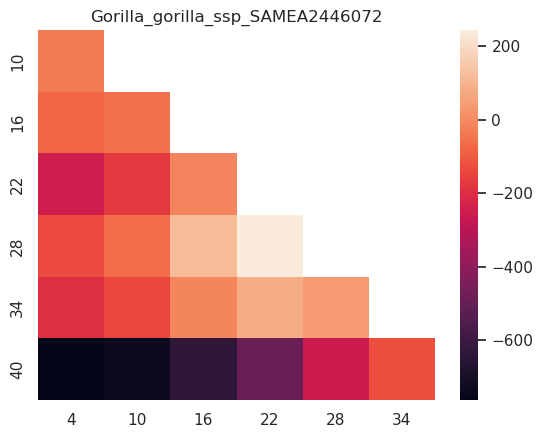

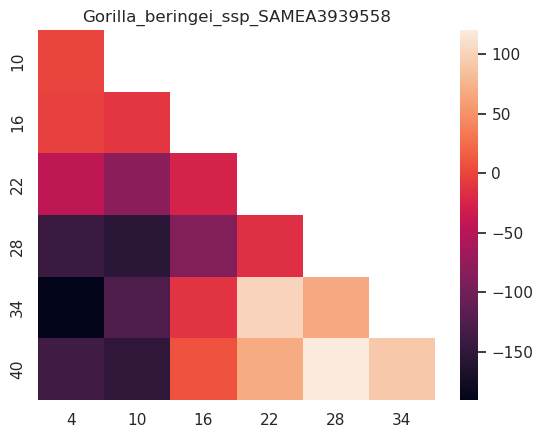

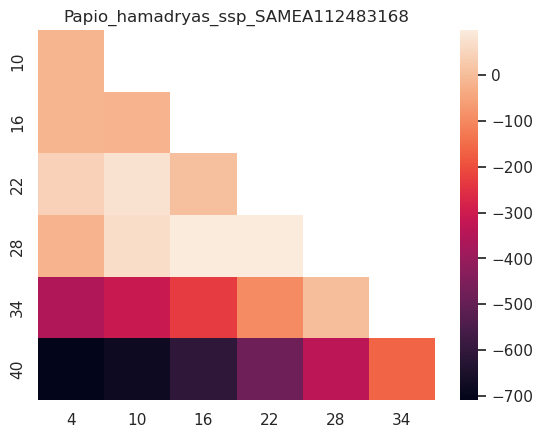

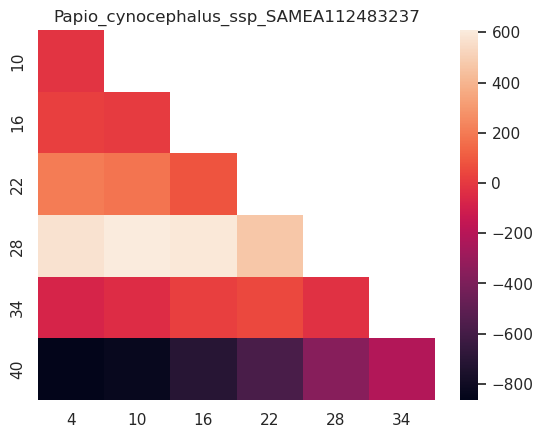

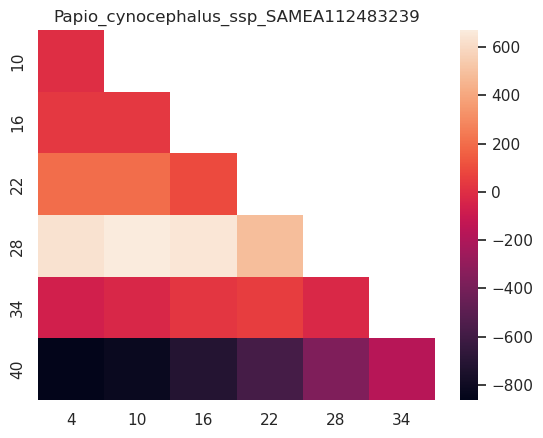

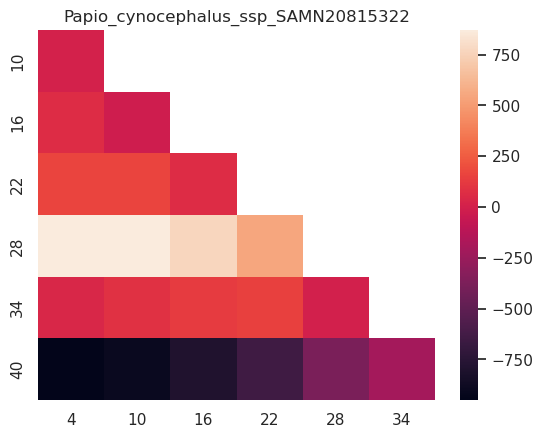

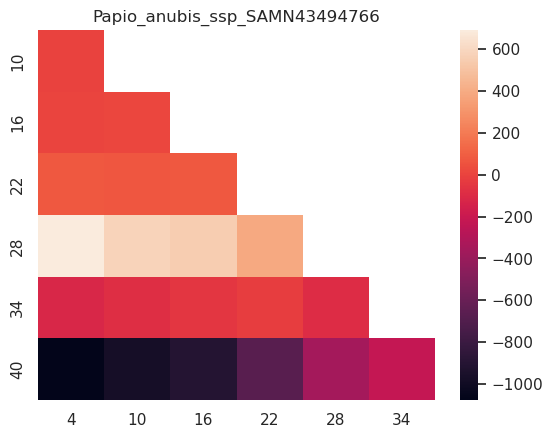

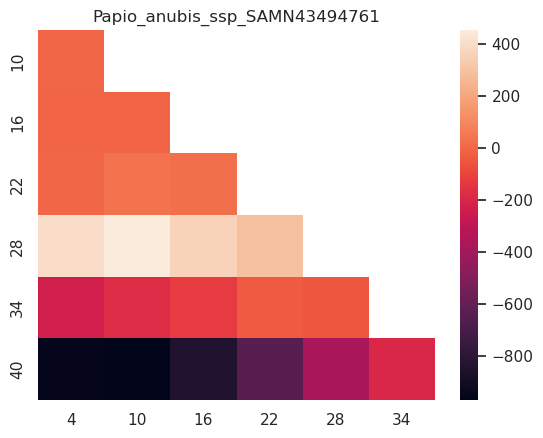

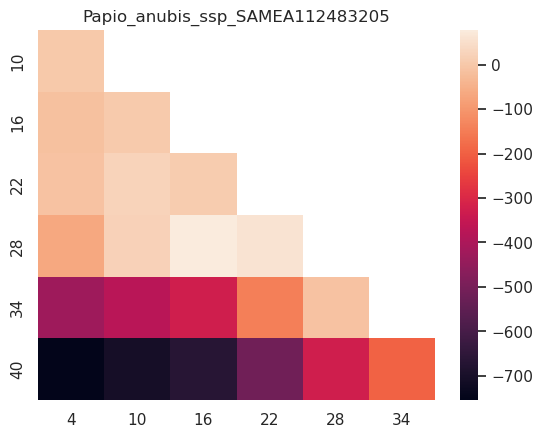

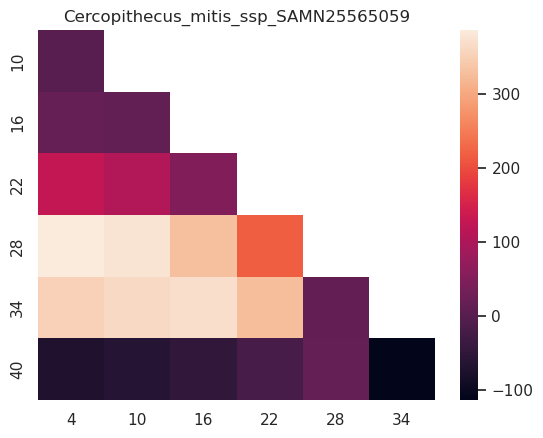

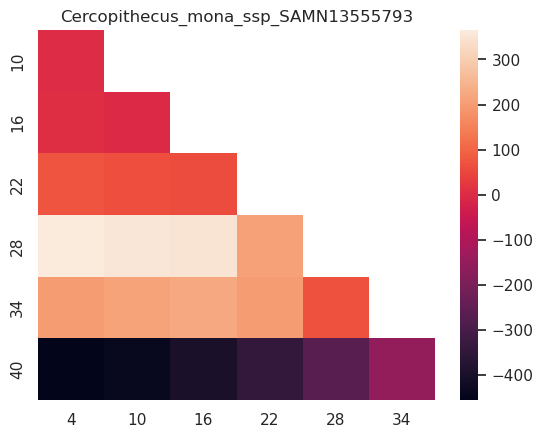

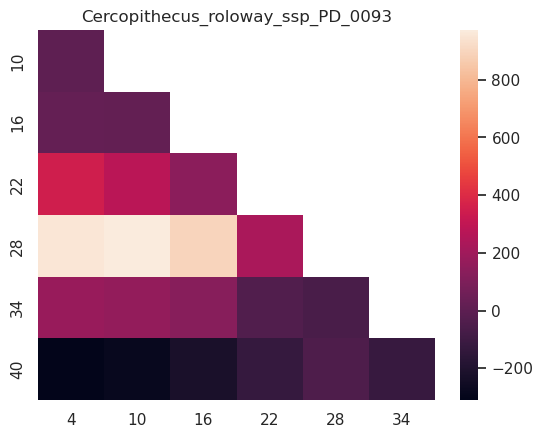

<Figure size 640x480 with 0 Axes>

In [10]:
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique()[:3]:
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            final_params_file_pan = f'../steps/cobraa/{ind}/aut_final_parameters.txt'
            pan_LL = get_LL_from_file(final_params_file_pan)
            matrix_LL_diffs = np.zeros(shape=(6,6))
            matrix_LL_diffs[:] = np.nan
            for te in range(10, 42, 6):
                for ts in range(4, te-4, 6):
                    final_params_file_struct = f'../steps/cobraa/{ind}/aut_D50_ts{ts}_te{te}_final_parameters.txt'
                    struct_LL = get_LL_from_file(final_params_file_struct)
                    diff_LL = struct_LL - pan_LL
                    matrix_LL_diffs[int((te-6)/6),int(ts/6)] = diff_LL
            matrix_LL_diffs = matrix_LL_diffs
            print(ind, pan_LL, np.nanmax(matrix_LL_diffs))
            g = sns.heatmap(matrix_LL_diffs)
            g.set(xticklabels=list(range(4, te-4, 6)), yticklabels=list(range(10, 42, 6)),title=gvcf_folder+"_"+ind)
            plt.figure()

Gorilla_gorilla_ssp
SAMEA2446072 -652243.5687251901 26.014402233297005
Gorilla_beringei_ssp
SAMEA3939558 -202220.447535633 27.41449953391566
Papio_hamadryas_ssp
SAMEA112483168 -425518.8182071274 82.24504018726293
Papio_cynocephalus_ssp
SAMEA112483237 -633569.1325686091 83.3309969608672
SAMEA112483239 -650352.7240880186 96.18545311829075
SAMN20815322 -606042.5508285104 204.18437335756607
Papio_anubis_ssp
SAMN43494766 -512822.5594990889 81.74459702440072
SAMN43494761 -608075.8970278957 128.81461884907912
SAMEA112483205 -419854.7522879994 24.04423670686083
Cercopithecus_mitis_ssp
SAMN25565059 -424988.1569878307 72.05194858292816
Cercopithecus_mona_ssp
SAMN13555793 -825570.9707146641 140.57750409923028
Cercopithecus_roloway_ssp
PD_0093 -913727.2219451455 241.13287259812932


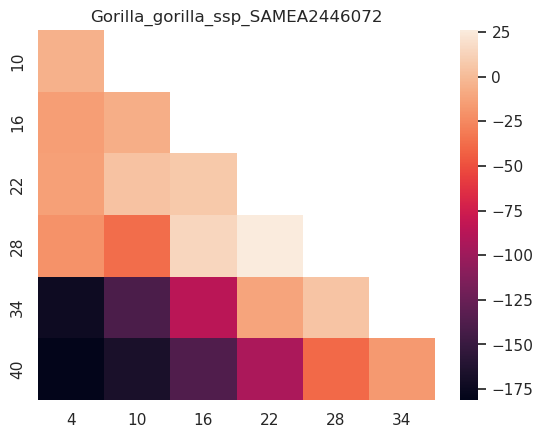

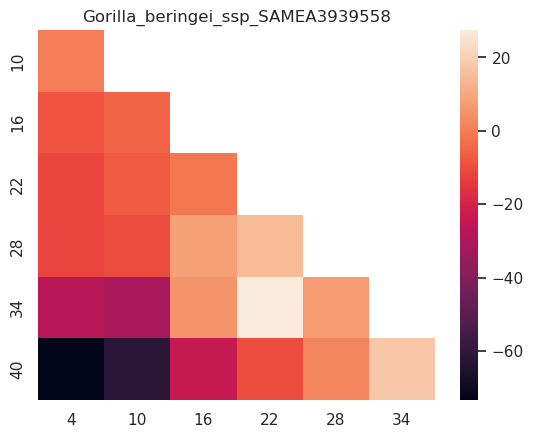

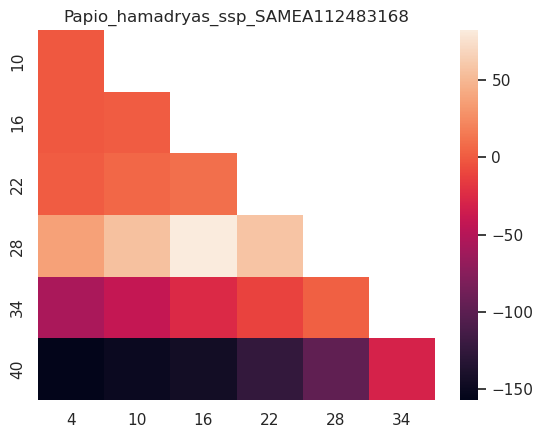

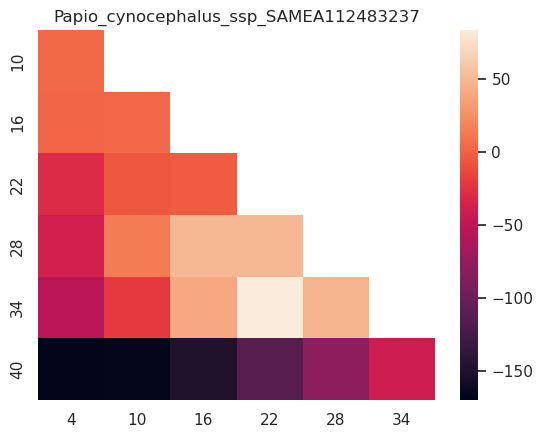

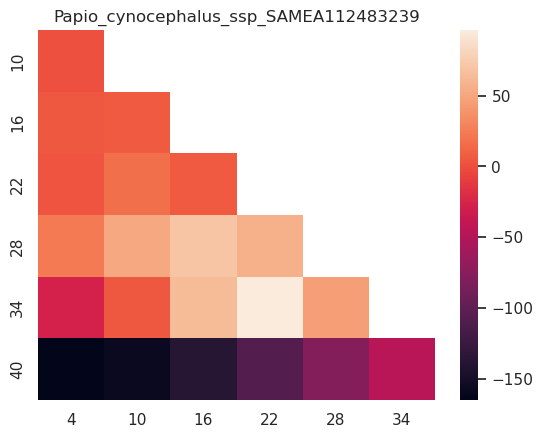

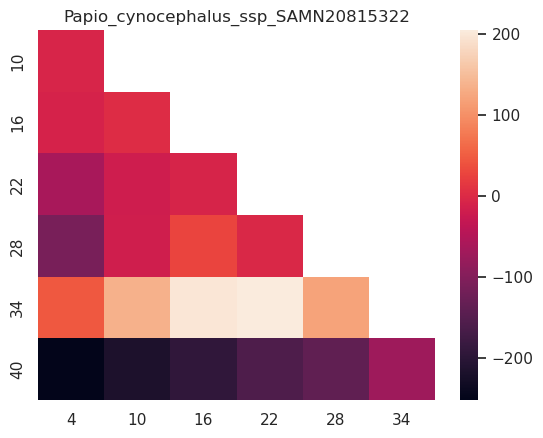

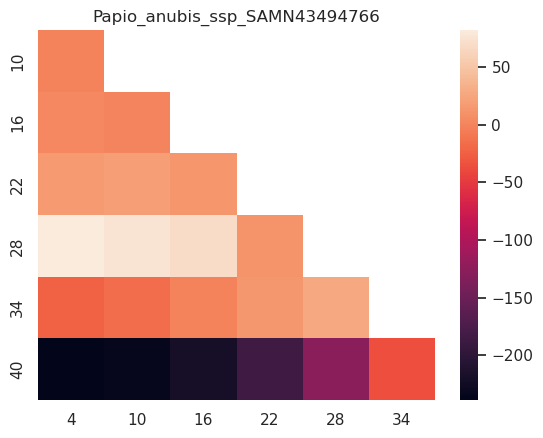

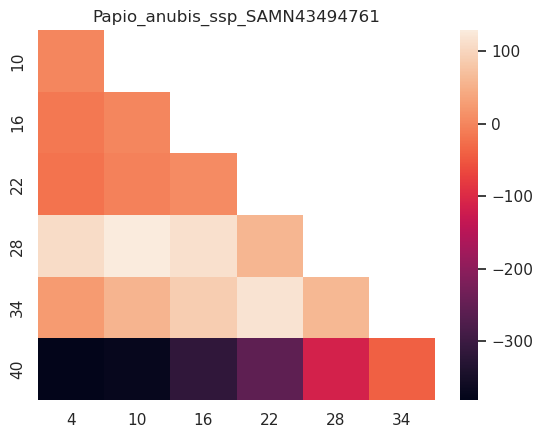

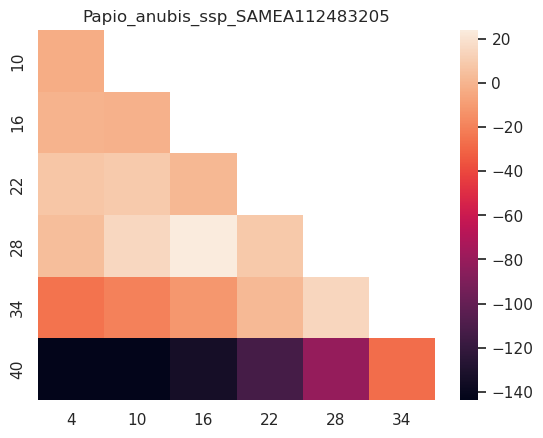

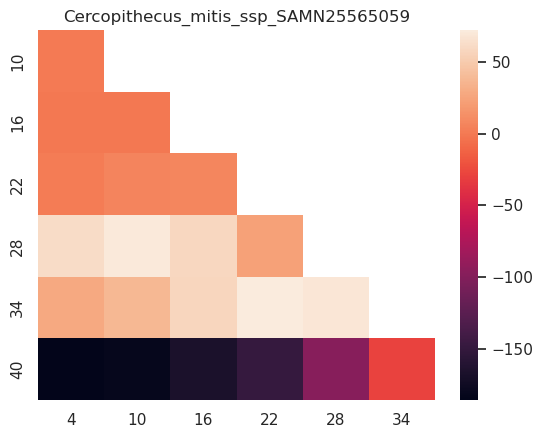

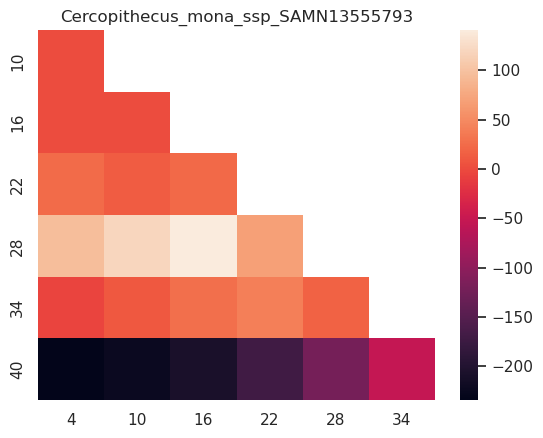

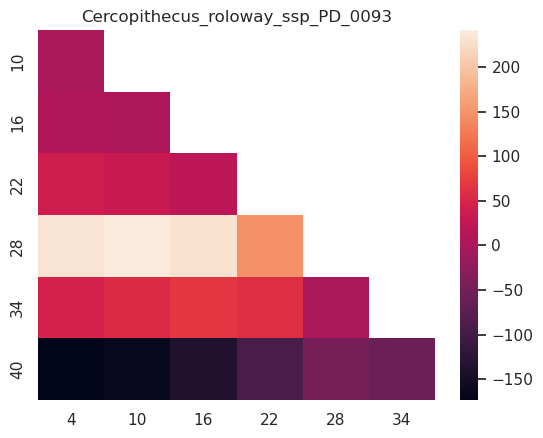

<Figure size 640x480 with 0 Axes>

In [11]:
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique()[:3]:
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            final_params_file_pan = f'../steps/cobraa/{ind}/chrX_final_parameters.txt'
            pan_LL = get_LL_from_file(final_params_file_pan)
            matrix_LL_diffs = np.zeros(shape=(6,6))
            matrix_LL_diffs[:] = np.nan
            for te in range(10, 42, 6):
                for ts in range(4, te-4, 6):
                    final_params_file_struct = f'../steps/cobraa/{ind}/chrX_D50_ts{ts}_te{te}_final_parameters.txt'
                    struct_LL = get_LL_from_file(final_params_file_struct)
                    diff_LL = struct_LL - pan_LL
                    matrix_LL_diffs[int((te-6)/6),int(ts/6)] = diff_LL
            matrix_LL_diffs = matrix_LL_diffs
            print(ind, pan_LL, np.nanmax(matrix_LL_diffs))
            g = sns.heatmap(matrix_LL_diffs)
            g.set(xticklabels=list(range(4, te-4, 6)), yticklabels=list(range(10, 42, 6)),title=gvcf_folder+"_"+ind)
            plt.figure()

Plotting the structured and unstructured population history per individual.

In [52]:
def find_best(file_list):
    best_param_file = None
    best_val = None
    # Go through the files and pick the 
    for p in file_list:
        LL = get_LL_from_file(p)
        if best_val == None:
            best_val = LL
            best_param_file = p
        if best_val < LL:
            best_val = LL
            best_param_file = p

    with open(best_param_file) as f:
        finallines = f.readlines()
    ztheta = float([i for i in finallines if 'theta' in i ][0].split(' ')[-1])
    zrho = float([i for i in finallines if 'rho' in i ][0].split(' ')[-1])
    zgamma = float([i for i in finallines if 'gamma' in i ][0].split(' ')[-1])
    file_name = best_param_file.split("/")[-1]
    zte = int(file_name.split("te")[1].split("_")[0])
    zts = int(file_name.split("ts")[1].split("_")[0])
    
    final_params = np.loadtxt(best_param_file)
    lambdaA_parameters = ",".join([str(x) for x in final_params[:,2]*ztheta/4])
    lambdaB_parameters = ",".join([str(x) for x in final_params[:,3]*ztheta/4])
    return zte, zts, ztheta, zrho, zgamma, lambdaA_parameters, lambdaB_parameters, best_param_file

Gorilla_gorilla_ssp
28 22 0.40011054369183324 ../steps/cobraa/SAMEA2446072/aut_D50_ts22_te28_final_parameters.txt
1.33e-08 22.0
Gorilla_beringei_ssp
40 28 0.28456602348717347 ../steps/cobraa/SAMEA3939558/aut_D50_ts28_te40_final_parameters.txt
1.2e-08 20.0
Papio_hamadryas_ssp
28 22 0.3202522969002373 ../steps/cobraa/SAMEA112483168/aut_D50_ts22_te28_final_parameters.txt
6.08e-09 15.0
Papio_cynocephalus_ssp
28 10 0.3112651330558519 ../steps/cobraa/SAMEA112483237/aut_D50_ts10_te28_final_parameters.txt
5.88e-09 17.0
28 10 0.3141705228482629 ../steps/cobraa/SAMEA112483239/aut_D50_ts10_te28_final_parameters.txt
5.88e-09 17.0
28 4 0.3320210131857827 ../steps/cobraa/SAMN20815322/aut_D50_ts4_te28_final_parameters.txt
5.88e-09 17.0
Papio_anubis_ssp
28 4 0.29583008055064125 ../steps/cobraa/SAMN43494766/aut_D50_ts4_te28_final_parameters.txt
3.91e-09 11.0
28 10 0.3214413158098224 ../steps/cobraa/SAMN43494761/aut_D50_ts10_te28_final_parameters.txt
3.91e-09 11.0
28 16 0.40115484370357746 ../steps/cobr

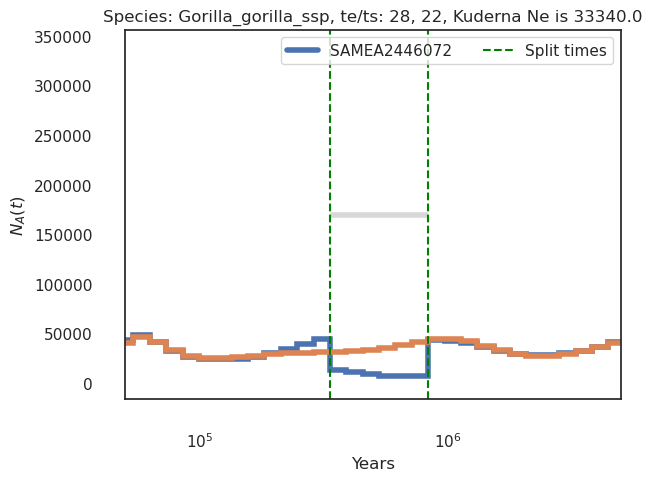

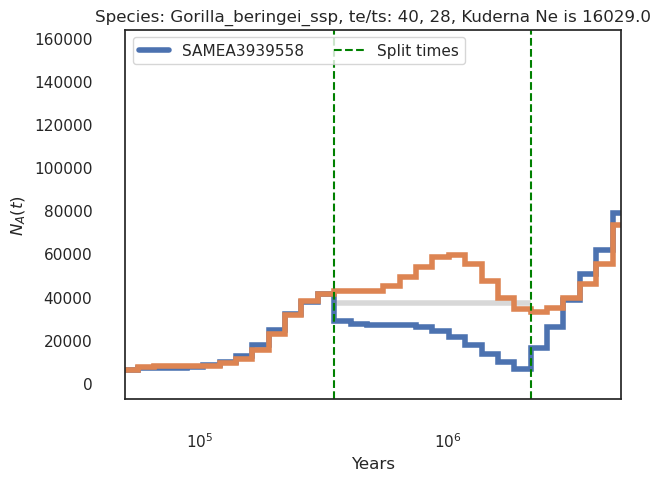

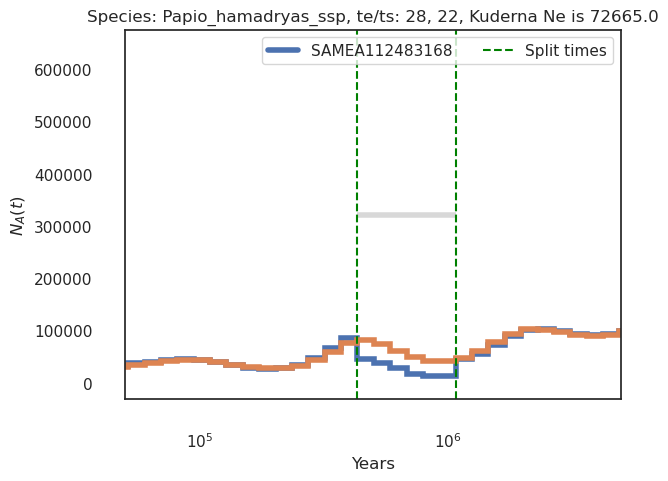

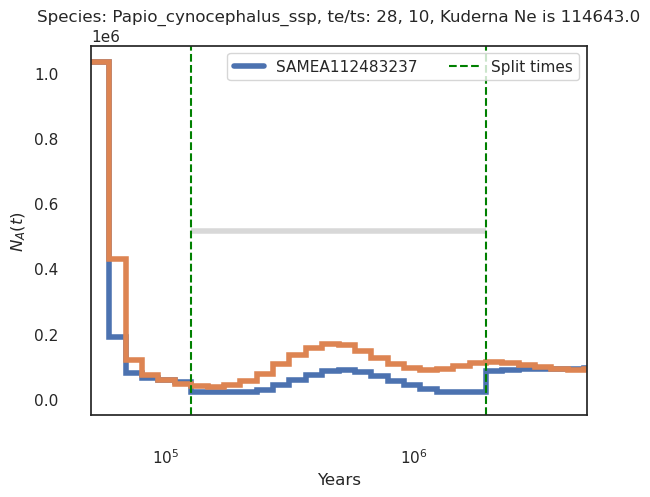

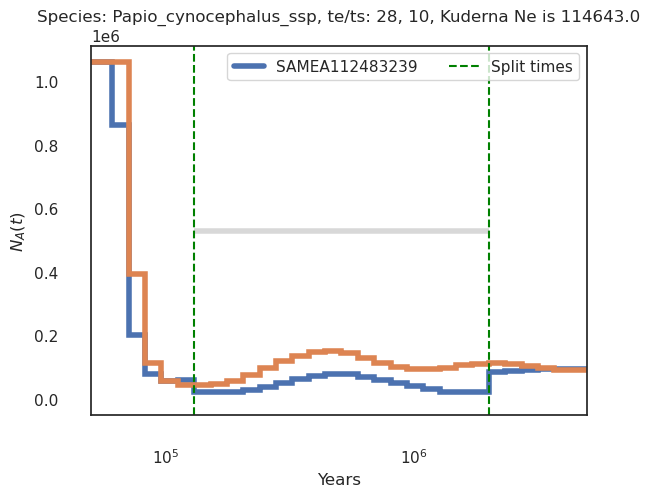

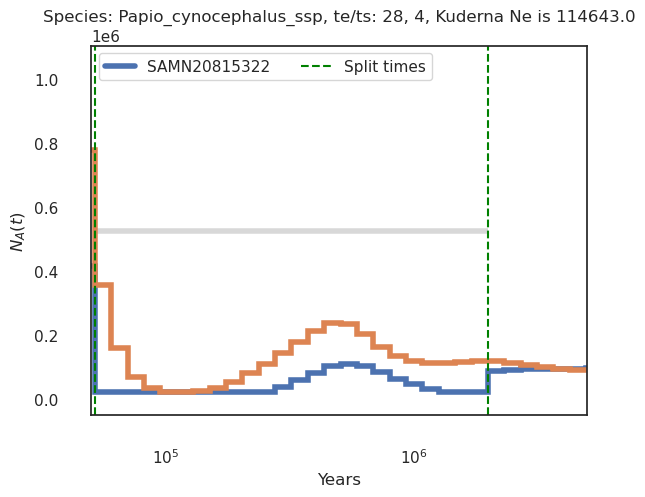

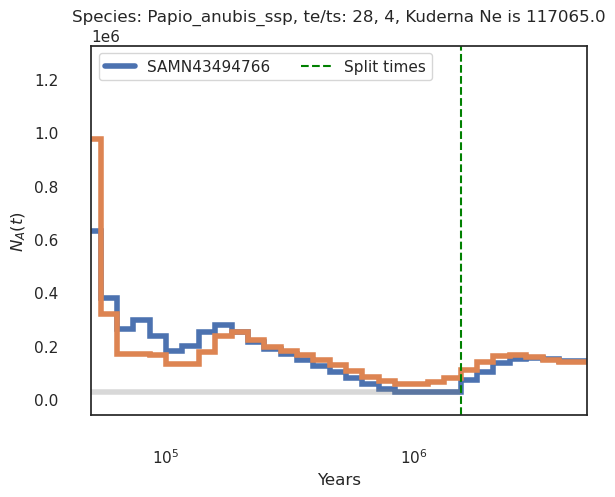

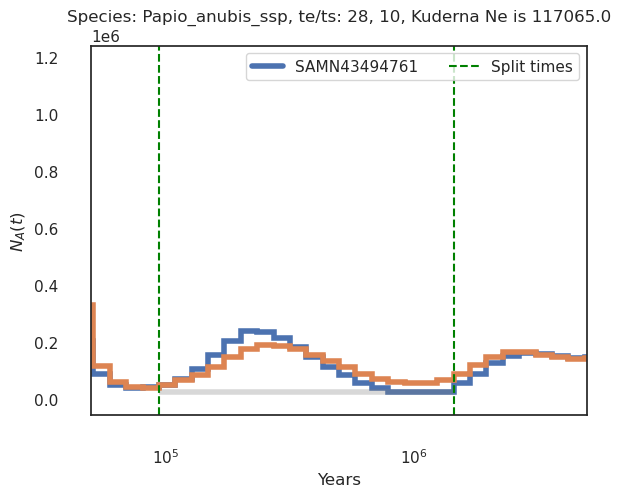

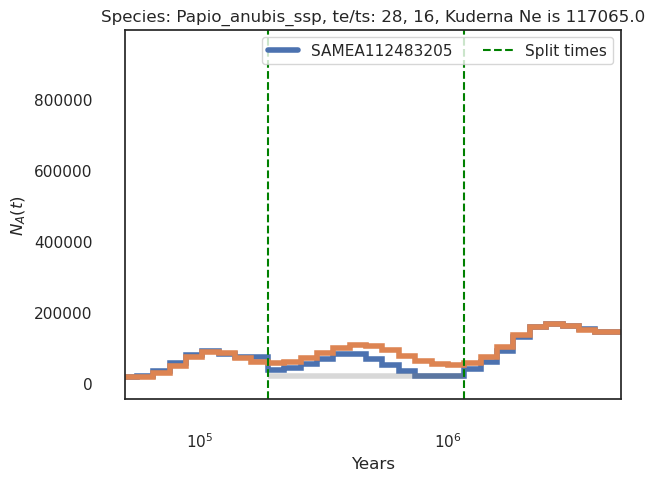

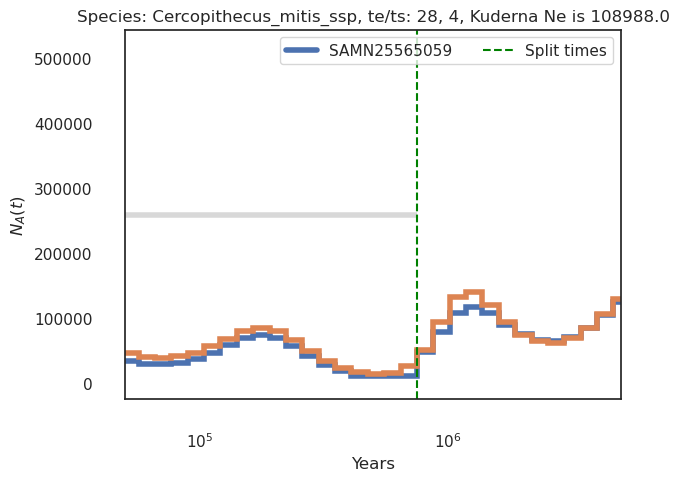

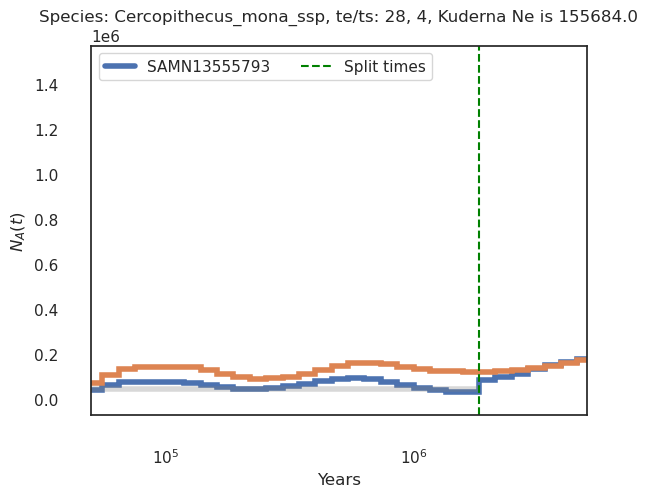

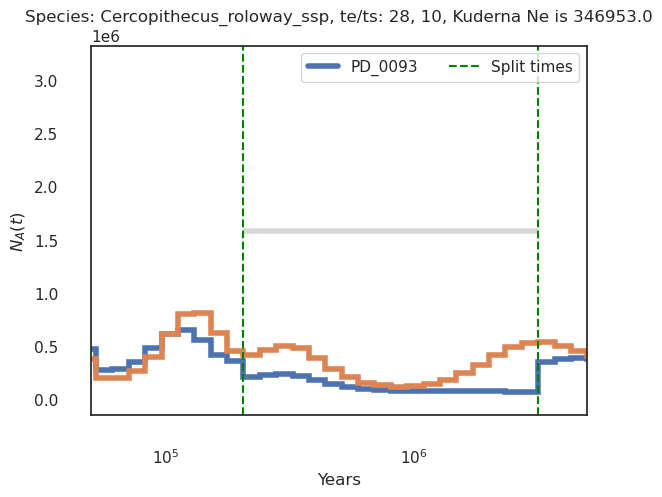

<Figure size 640x480 with 0 Axes>

In [61]:
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique()[:3]:
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            structured_files = glob.glob(f'../steps/cobraa/{ind}/aut_D50_ts*_te*_final_parameters.txt')
            zte, zts, ztheta, zrho, zgamma, lambdaA_parameters, lambdaB_parameters, best_param_file = find_best(structured_files)
            label_tag = best_param_file.split("/")[-2]
            print(zte, zts, zgamma, best_param_file)
            ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
            gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
            gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
            g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
            if len(gs_df) > 0:
                mu = gs_df.MU_PER_GENERATION.mean()
                gen = gs_df.GENERATION_LENGTH.mean()
                kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
            elif len(g_df) > 0:
                mu = g_df.MU_PER_GENERATION.mean()
                gen = g_df.GENERATION_LENGTH.mean()
                kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
            print(mu, gen)
            final_params = np.loadtxt(best_param_file)
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.stairs(edges=(time_array[zts:zte+1]/mu)*gen,values=(1/final_params[zts:zte,3])/mu,label='',linewidth=4,linestyle="solid",baseline=None,color="grey",alpha=0.3)
            plt.axvline((time_array[zts]/mu)*gen,color="green",linestyle="dashed")  
            plt.axvline((time_array[zte]/mu)*gen,label="Split times",color="green",linestyle="dashed")    
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.legend(ncol=2)
            # Unstructured for comp
            final_params = np.loadtxt(f'../steps/cobraa/{ind}/aut_final_parameters.txt')
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.title("Species: {}, te/ts: {}, {}, Kuderna Ne is {}".format(gvcf_folder, zte, zts, kuderna_Ne))
            plt.figure()

Gorilla_gorilla_ssp
28 22 0.3423120846962198 ../steps/cobraa/SAMEA2446072/chrX_D50_ts22_te28_final_parameters.txt
1.0640000000000001e-08 22.0
Gorilla_beringei_ssp
34 22 0.34550426045478483 ../steps/cobraa/SAMEA3939558/chrX_D50_ts22_te34_final_parameters.txt
9.6e-09 20.0
Papio_hamadryas_ssp
28 16 0.33206550361186865 ../steps/cobraa/SAMEA112483168/chrX_D50_ts16_te28_final_parameters.txt
4.864e-09 15.0
Papio_cynocephalus_ssp
34 22 0.22760898211315875 ../steps/cobraa/SAMEA112483237/chrX_D50_ts22_te34_final_parameters.txt
4.704e-09 17.0
34 22 0.21746805903169705 ../steps/cobraa/SAMEA112483239/chrX_D50_ts22_te34_final_parameters.txt
4.704e-09 17.0
34 22 0.3147781305928809 ../steps/cobraa/SAMN20815322/chrX_D50_ts22_te34_final_parameters.txt
4.704e-09 17.0
Papio_anubis_ssp
28 4 0.43179634607550016 ../steps/cobraa/SAMN43494766/chrX_D50_ts4_te28_final_parameters.txt
3.128e-09 11.0
28 10 0.4646909800714205 ../steps/cobraa/SAMN43494761/chrX_D50_ts10_te28_final_parameters.txt
3.128e-09 11.0
28 16 0

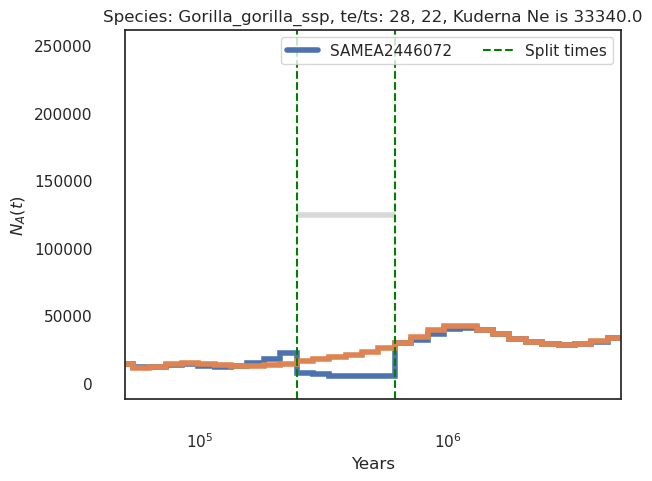

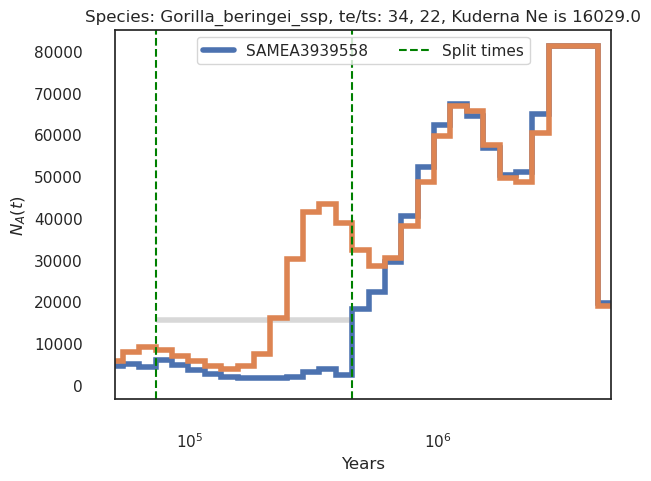

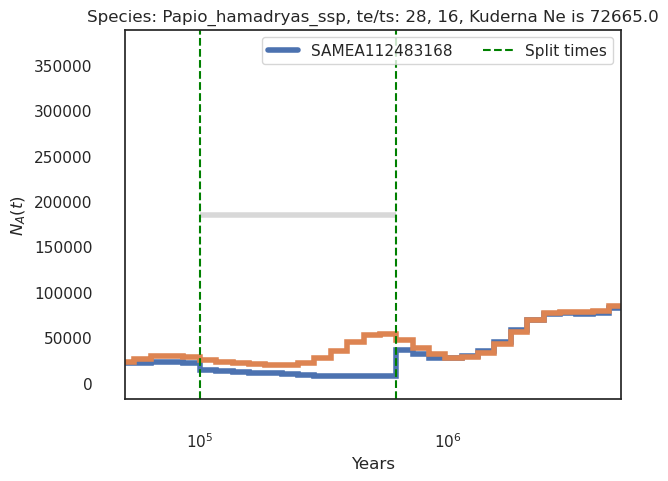

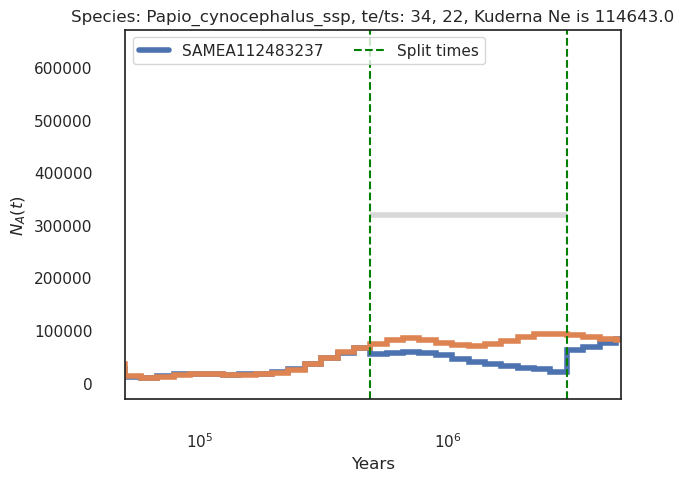

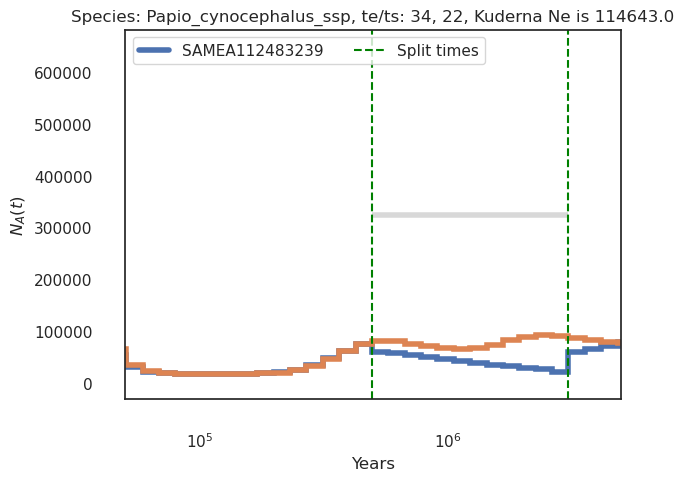

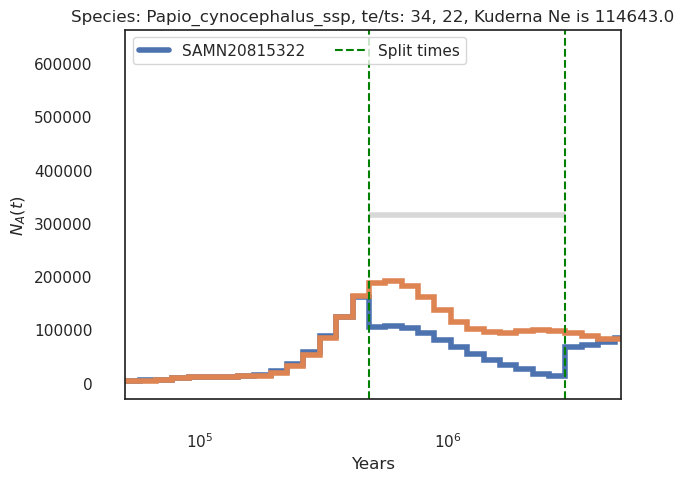

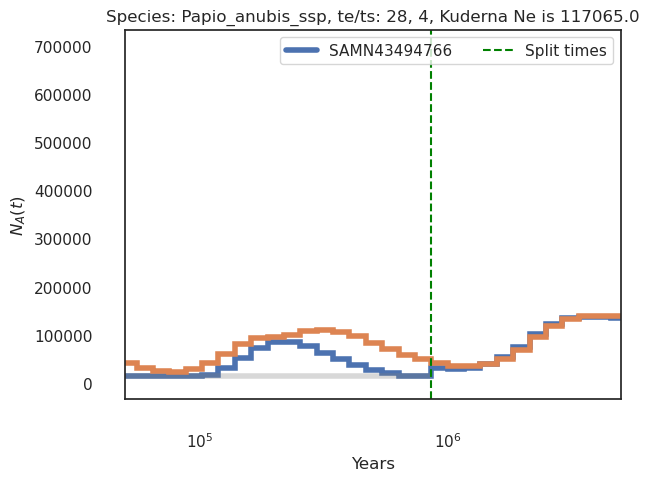

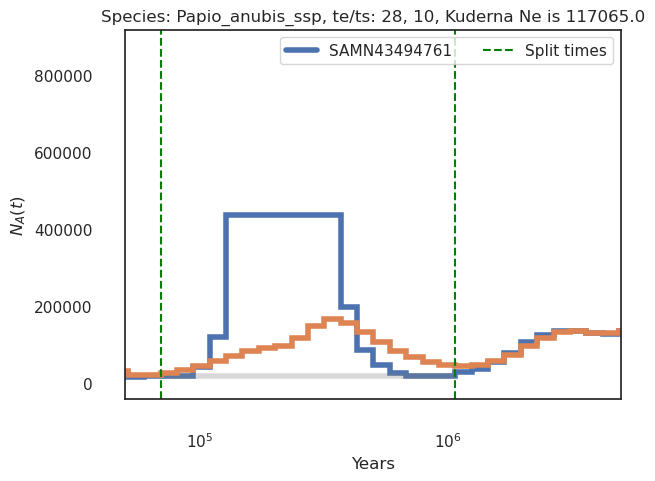

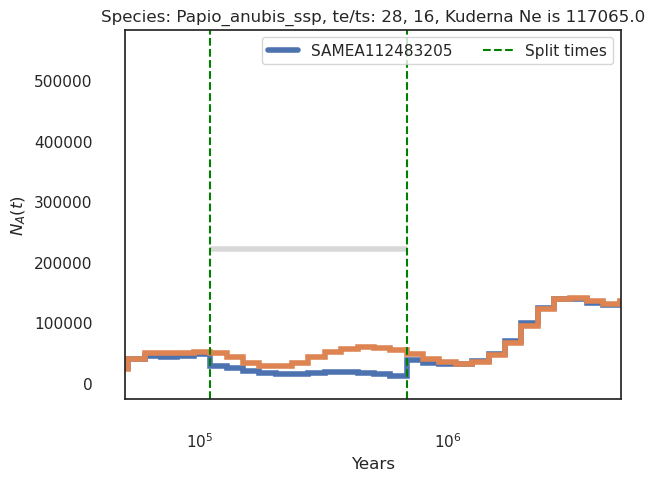

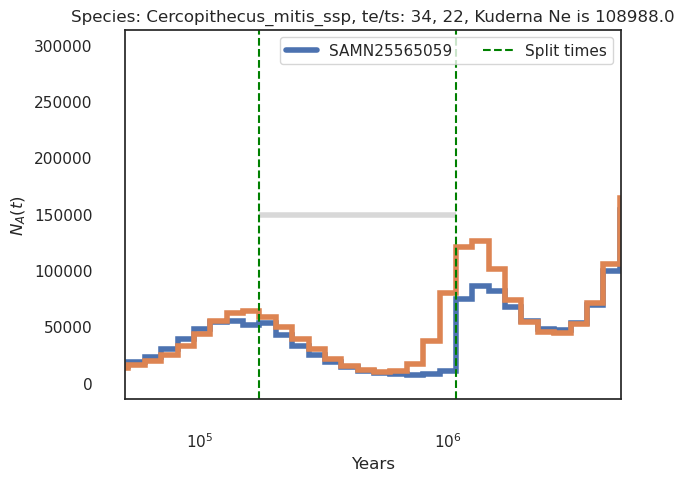

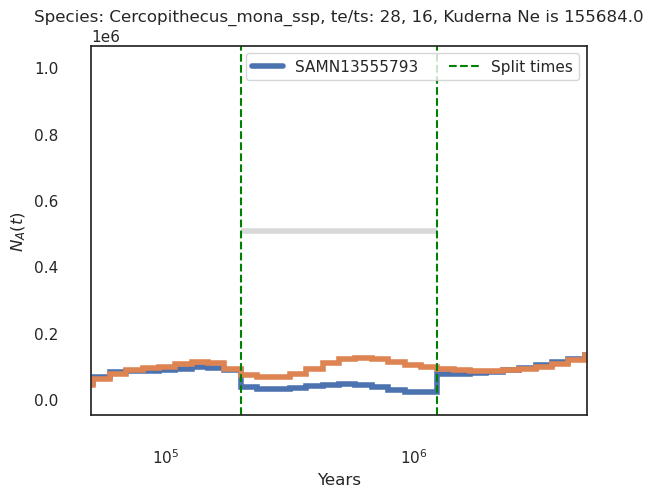

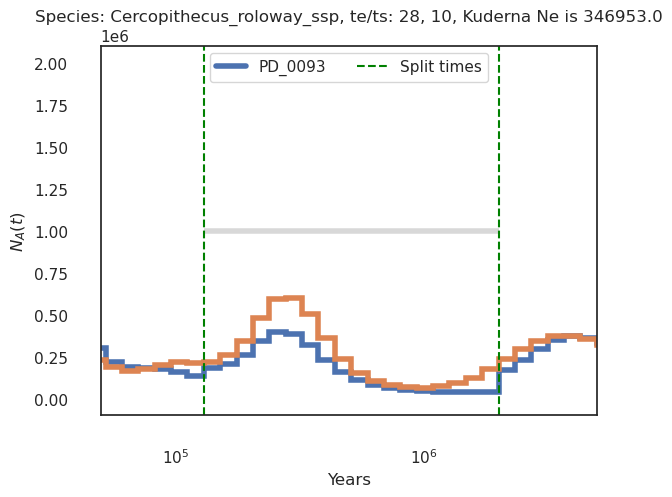

<Figure size 640x480 with 0 Axes>

In [63]:
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique()[:3]:
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            structured_files = glob.glob(f'../steps/cobraa/{ind}/chrX_D50_ts*_te*_final_parameters.txt')
            zte, zts, ztheta, zrho, zgamma, lambdaA_parameters, lambdaB_parameters, best_param_file = find_best(structured_files)
            label_tag = best_param_file.split("/")[-2]
            print(zte, zts, zgamma, best_param_file)
            ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
            gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
            gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
            g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
            if len(gs_df) > 0:
                mu = gs_df.MU_PER_GENERATION.mean()*0.8
                gen = gs_df.GENERATION_LENGTH.mean()
                kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
            elif len(g_df) > 0:
                mu = g_df.MU_PER_GENERATION.mean()*0.8
                gen = g_df.GENERATION_LENGTH.mean()
                kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
            print(mu, gen)
            final_params = np.loadtxt(best_param_file)
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.stairs(edges=(time_array[zts:zte+1]/mu)*gen,values=(1/final_params[zts:zte,3])/mu,label='',linewidth=4,linestyle="solid",baseline=None,color="grey",alpha=0.3)
            plt.axvline((time_array[zts]/mu)*gen,color="green",linestyle="dashed")  
            plt.axvline((time_array[zte]/mu)*gen,label="Split times",color="green",linestyle="dashed")    
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.legend(ncol=2)
            # Unstructured for comp
            final_params = np.loadtxt(f'../steps/cobraa/{ind}/chrX_final_parameters.txt')
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.title("Species: {}, te/ts: {}, {}, Kuderna Ne is {}".format(gvcf_folder, zte, zts, kuderna_Ne))
            plt.figure()

Gorilla_gorilla_ssp
28 22 0.3423120846962198 ../steps/cobraa/SAMEA2446072/chrX_D50_ts22_te28_final_parameters.txt
7.98e-09 22.0
Gorilla_gorilla_ssp
28 22 0.3423120846962198 ../steps/cobraa/SAMEA2446072/chrX_D50_ts22_te28_final_parameters.txt
1.0640000000000001e-08 22.0
Gorilla_gorilla_ssp
28 22 0.3423120846962198 ../steps/cobraa/SAMEA2446072/chrX_D50_ts22_te28_final_parameters.txt
1.33e-08 22.0


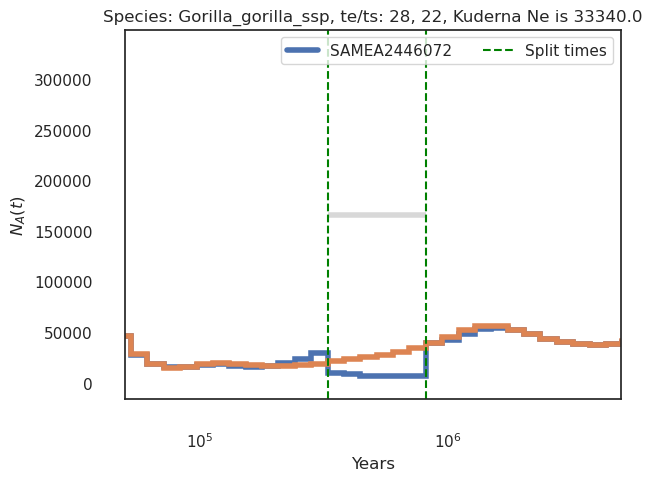

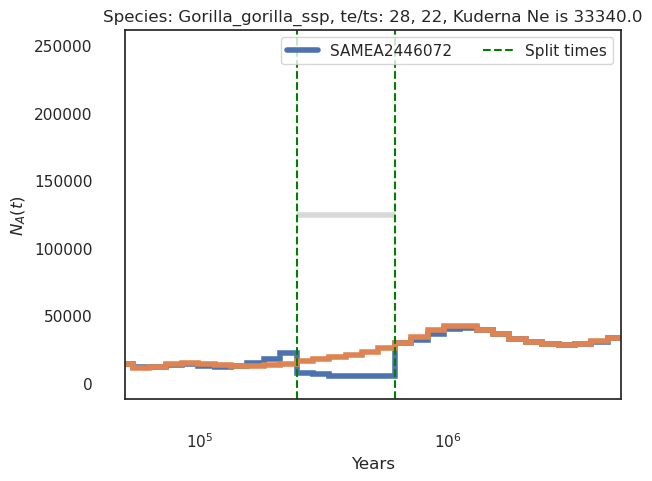

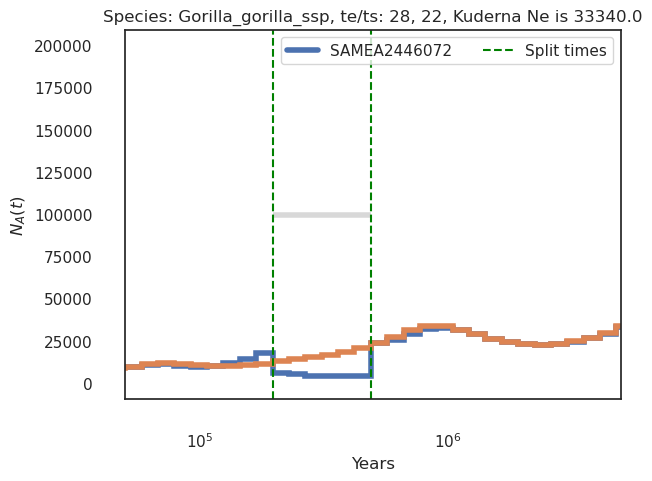

<Figure size 640x480 with 0 Axes>

In [67]:
for m_scale in [0.6, 0.8, 1]:
    d = '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Gorilla_individuals.txt'
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique()[:1]:
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            structured_files = glob.glob(f'../steps/cobraa/{ind}/chrX_D50_ts*_te*_final_parameters.txt')
            zte, zts, ztheta, zrho, zgamma, lambdaA_parameters, lambdaB_parameters, best_param_file = find_best(structured_files)
            label_tag = best_param_file.split("/")[-2]
            print(zte, zts, zgamma, best_param_file)
            ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
            gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
            gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
            g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
            if len(gs_df) > 0:
                mu = gs_df.MU_PER_GENERATION.mean()*m_scale
                gen = gs_df.GENERATION_LENGTH.mean()
                kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
            elif len(g_df) > 0:
                mu = g_df.MU_PER_GENERATION.mean()*m_scale
                gen = g_df.GENERATION_LENGTH.mean()
                kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
            print(mu, gen)
            final_params = np.loadtxt(best_param_file)
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.stairs(edges=(time_array[zts:zte+1]/mu)*gen,values=(1/final_params[zts:zte,3])/mu,label='',linewidth=4,linestyle="solid",baseline=None,color="grey",alpha=0.3)
            plt.axvline((time_array[zts]/mu)*gen,color="green",linestyle="dashed")  
            plt.axvline((time_array[zte]/mu)*gen,label="Split times",color="green",linestyle="dashed")    
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.legend(ncol=2)
            # Unstructured for comp
            final_params = np.loadtxt(f'../steps/cobraa/{ind}/chrX_final_parameters.txt')
            time_array = list(final_params[:,1])
            time_array.insert(0,0)
            time_array = np.array(time_array)
            plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
            plt.xlim(5e+04,5e+06)
            #plt.ylim(0,20e+04)
            plt.xscale('log')
            plt.ylabel('$N_A(t)$')
            plt.xlabel('Years')
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
            plt.title("Species: {}, te/ts: {}, {}, Kuderna Ne is {}".format(gvcf_folder, zte, zts, kuderna_Ne))
            plt.figure()

I generally dislike the "look" of results for ts 4, so I should probably restrict it to searching in the ts8/te38 range or something like that.
Then the search can start with increment 6, and then a plusminus search of 4.